In [1]:
from dotenv import load_dotenv

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import os

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

# TextBlob
from textblob import TextBlob

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

# nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package vader_lexicon to /home/m9/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# load .env
load_dotenv() 

#sns.color_palette("rocket_r", as_cmap=True)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
#plt.rcParams.update({'font.size': 22})

# random seed
np.random.seed(42)


# ignore warnings
import warnings
#warnings.filterwarnings("ignore")

### Set hugging credential

In [3]:
hugging_api_key = os.environ["HF_API_KEY"]

### Check directory files

In [4]:
!ls

get_tweets_using_tweepy.ipynb  TweetDataset.csv
images			       Tweets_Sentiment_Analysis_Results.csv
Processed_Tweets_Dataset.csv   twitter_analysis.py
Sentiment_analysis.ipynb       venv


In [5]:
df = pd.read_csv("Processed_Tweets_Dataset.csv")
df.drop(columns=["Date", "User", "IsVerified", "Likes", "RT", "User_location"], inplace=True)
print(df.shape)
df.head()

(1000, 2)


,Tweet,clean_tweet
0,@ManUtd Chelsea V Manchester United tickets av...,manutd chelsea manchester united tickets avail...
1,"Pete and Julie reviewing the Chelsea game, pre...",pete julie reviewing chelsea game previewing v...
2,Ready Go.\n#chelsea | #Con | #foot https://t.c...,ready go chelsea con foot https
3,@Mattsson123 N.Forest 0-3 Liverpool\nEverton 0...,liverpool everton man city brighton chelsea ma...
4,@Cristiano good day!\nPlease join Chelsea to s...,cristiano good day please join chelsea shine c...


In [6]:
def word_cloud(df, column_name="Tweet"):
    #create instance of the WordCloud() 
    word_cloud = WordCloud(height=1080, width=2048, background_color='white')

    #get the text in a big string
    txt = df[column_name].str.lower()
    text=" ".join([str(word) for word in txt])

    #generate the word cloud
    word_cloud.generate(text)

    #display now
    plt.figure(figsize=(14, 12));
    plt.imshow(word_cloud);
    plt.axis("off");
    plt.title(f"Most {column_name} Common Words");

In [7]:
def get_top_tweet_bigrams(df, column_name="Tweet", ngram=2, n=None):
    # select all text for selected dialect
    txt = df[column_name].str.lower()
    # create a matrix of token counts
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(txt)
    # bag of words  
    bag_of_words = vec.transform(txt)
    # sum bag of words 
    sum_words = bag_of_words.sum(axis=0) 
    # frequency of each word in selected texts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # top n words repeates in selected texts 
    top = words_freq[:n]
    #print(top)
    x, y = map( list, zip(*top) )
    nn = np.arange(len(x))
    
    plt.figure(figsize=(10,8))
    plt.barh(x, y, align='center', alpha=0.2)
    plt.plot(y, nn, '-o', markersize=5, alpha=0.8)
    plt.yticks(nn, x);
    plt.xlabel('Word Number');
    plt.title(f'Top {n} words in  tweets')

In [8]:
sample_tweet = df.clean_tweet[0]
sample_tweet

'manutd chelsea manchester united tickets available sale Direct Message'

In [9]:
df["clean_tweet"].isnull().sum()

0

## Analyze Sentiment using NLTK SentimentIntensityAnalyzer

In [10]:
analysis = SentimentIntensityAnalyzer()

In [11]:
sentiments = SentimentIntensityAnalyzer()
df['scores_1'] = [sentiments.polarity_scores(i)["compound"] for i in df["clean_tweet"]]
df.head()

,Tweet,clean_tweet,scores_1
0,@ManUtd Chelsea V Manchester United tickets av...,manutd chelsea manchester united tickets avail...,0.4215
1,"Pete and Julie reviewing the Chelsea game, pre...",pete julie reviewing chelsea game previewing v...,-0.2263
2,Ready Go.\n#chelsea | #Con | #foot https://t.c...,ready go chelsea con foot https,0.3612
3,@Mattsson123 N.Forest 0-3 Liverpool\nEverton 0...,liverpool everton man city brighton chelsea ma...,0.0000
4,@Cristiano good day!\nPlease join Chelsea to s...,cristiano good day please join chelsea shine c...,0.7506


In [12]:
def Analysis_Sentiment(score):
    if score >= 0.05 :
        return 'Positive'
    elif score <= -0.05 :
        return 'Negative'
    else:
        return 'Neutral'
        
Analysis_Sentiment(0), Analysis_Sentiment(.1), Analysis_Sentiment(-.1), Analysis_Sentiment(.5)

('Neutral', 'Positive', 'Negative', 'Positive')

In [13]:
df["Sentiment_1"] = df["scores_1"].map(lambda score: Analysis_Sentiment(score))
df.head()

,Tweet,clean_tweet,scores_1,Sentiment_1
0,@ManUtd Chelsea V Manchester United tickets av...,manutd chelsea manchester united tickets avail...,0.4215,Positive
1,"Pete and Julie reviewing the Chelsea game, pre...",pete julie reviewing chelsea game previewing v...,-0.2263,Negative
2,Ready Go.\n#chelsea | #Con | #foot https://t.c...,ready go chelsea con foot https,0.3612,Positive
3,@Mattsson123 N.Forest 0-3 Liverpool\nEverton 0...,liverpool everton man city brighton chelsea ma...,0.0000,Neutral
4,@Cristiano good day!\nPlease join Chelsea to s...,cristiano good day please join chelsea shine c...,0.7506,Positive


## Analyze Sentiment using huggingface Pipline

In [14]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="Seethal/sentiment_analysis_generic_dataset")
sentiment_pipeline(sample_tweet)

[{'label': 'LABEL_0', 'score': 0.9737673997879028}]

In [15]:
sentiment_results = sentiment_pipeline(df.clean_tweet.tolist())
sentiment_results = pd.DataFrame(sentiment_results)
sentiment_results.head(10)

,label,score
0,LABEL_0,0.973767
1,LABEL_0,0.630749
2,LABEL_1,0.712159
3,LABEL_1,0.994480
4,LABEL_2,0.989573
5,LABEL_2,0.989467
6,LABEL_1,0.421530
7,LABEL_0,0.949205
8,LABEL_1,0.995530
9,LABEL_2,0.990206


In [16]:
labels = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive',
}

In [17]:
df['scores_2'] = sentiment_results.score
df["Sentiment_2"] = sentiment_results.label.map(labels)
df.head(20)

,Tweet,clean_tweet,scores_1,Sentiment_1,scores_2,Sentiment_2
0,@ManUtd Chelsea V Manchester United tickets av...,manutd chelsea manchester united tickets avail...,0.4215,Positive,0.973767,Negative
1,"Pete and Julie reviewing the Chelsea game, pre...",pete julie reviewing chelsea game previewing v...,-0.2263,Negative,0.630749,Negative
2,Ready Go.\n#chelsea | #Con | #foot https://t.c...,ready go chelsea con foot https,0.3612,Positive,0.712159,Neutral
3,@Mattsson123 N.Forest 0-3 Liverpool\nEverton 0...,liverpool everton man city brighton chelsea ma...,0.0000,Neutral,0.994480,Neutral
4,@Cristiano good day!\nPlease join Chelsea to s...,cristiano good day please join chelsea shine c...,0.7506,Positive,0.989573,Positive
5,"chelsea fans have a good night rest today, cos...",chelsea fans good night rest today cos sleep w...,0.6124,Positive,0.989467,Positive
6,@honkelechinwogu Chelsea 0 man u 2,honkelechinwogu chelsea man,0.0000,Neutral,0.421530,Neutral
7,"Hey lads,I’m selling Out (x2) tickets each of ...",hey lads selling tickets tickets want eventual...,-0.1779,Negative,0.949205,Negative
8,"Ten Hag: “Cristiano is not in the squad, but h...",ten hag cristiano squad training keep fit get ...,0.6124,Positive,0.995530,Neutral
9,@EdmundOris Chelsea go win,edmundoris chelsea go win,0.5859,Positive,0.990206,Positive


In [19]:
sentiment_percentage = df["Sentiment_1"].value_counts().sort_values(ascending=False)
sentiment_percentage

Positive    532
Neutral     335
Negative    133
Name: Sentiment_1, dtype: int64

In [20]:
sentiment_percentage = df["Sentiment_2"].value_counts().sort_values(ascending=False)
sentiment_percentage

Neutral     430
Negative    359
Positive    211
Name: Sentiment_2, dtype: int64

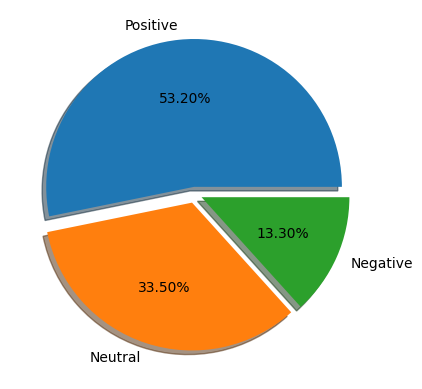

In [21]:
plt.pie(
    df["Sentiment_1"].value_counts(),
    shadow = True,
    explode = (0.05, 0.06, 0.05),
    labels = df["Sentiment_1"].value_counts().index,
    autopct = '%1.2f%%'
);

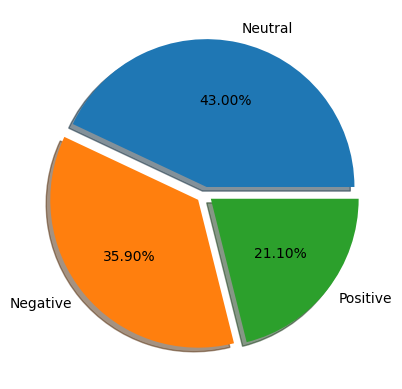

In [32]:
plt.pie(
    df["Sentiment_2"].value_counts(),
    shadow = True,
    explode = (0.05, 0.06, 0.05),
    labels = df["Sentiment_2"].value_counts().index,
    autopct = '%1.2f%%'
);

In [23]:
positive_df = df[df.Sentiment_2=='Positive']
neutral_df = df[df.Sentiment_2=='Neutral']
negative_df = df[df.Sentiment_2=='Negative']

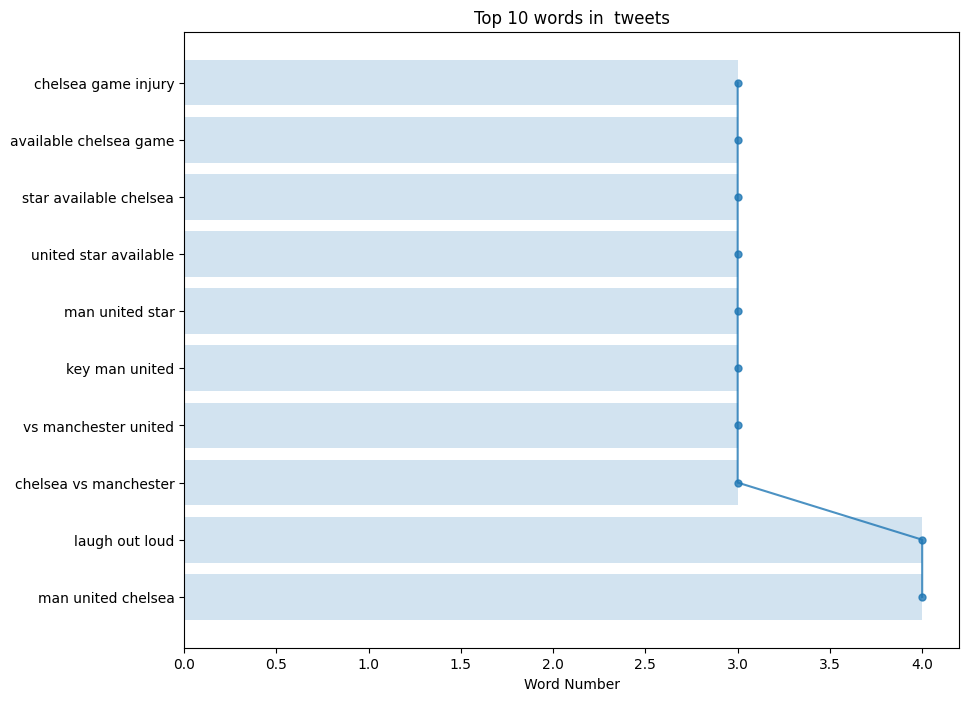

In [24]:
get_top_tweet_bigrams(positive_df, column_name="clean_tweet", ngram=3, n=10)

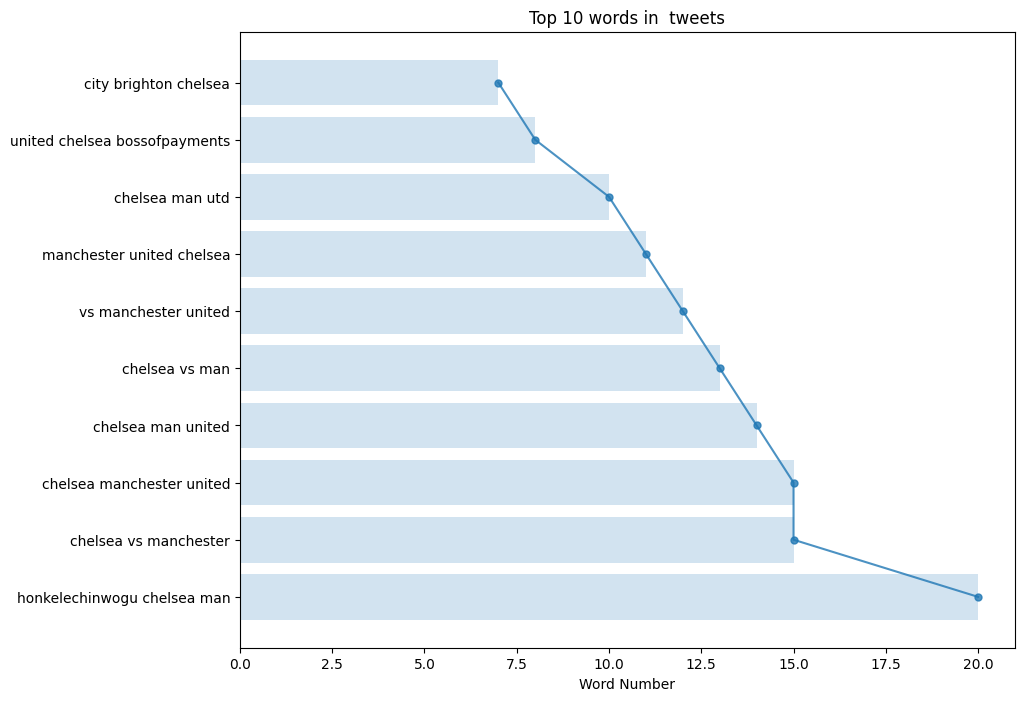

In [25]:
get_top_tweet_bigrams(neutral_df, column_name="clean_tweet", ngram=3, n=10)

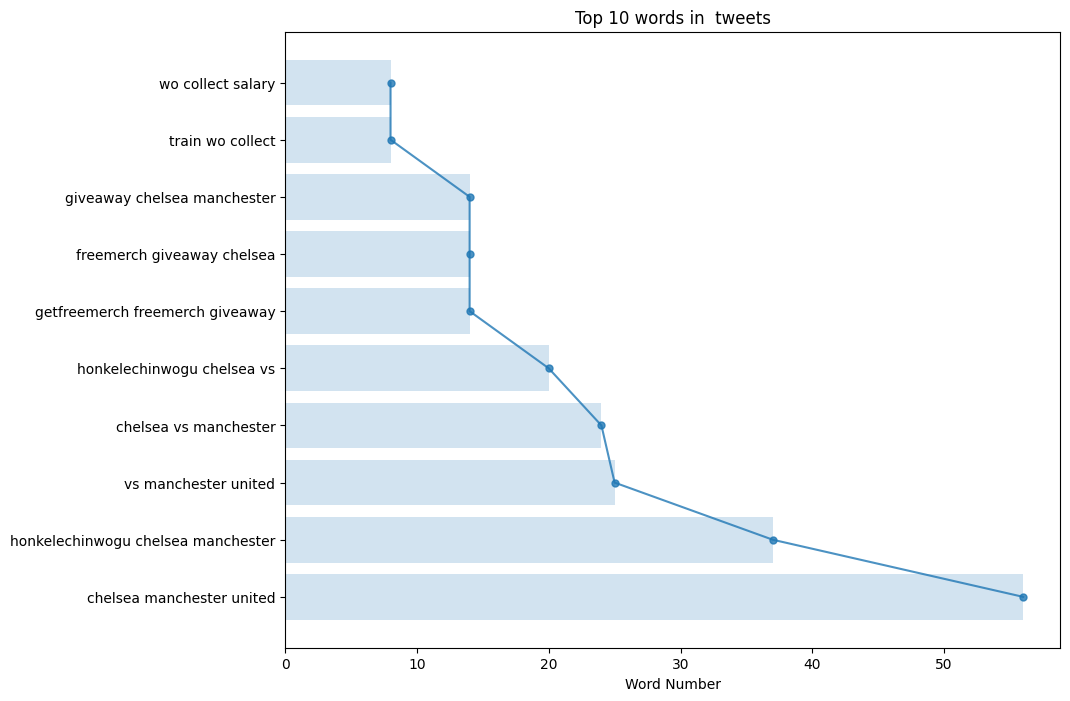

In [26]:
get_top_tweet_bigrams(negative_df, column_name="clean_tweet", ngram=3, n=10)

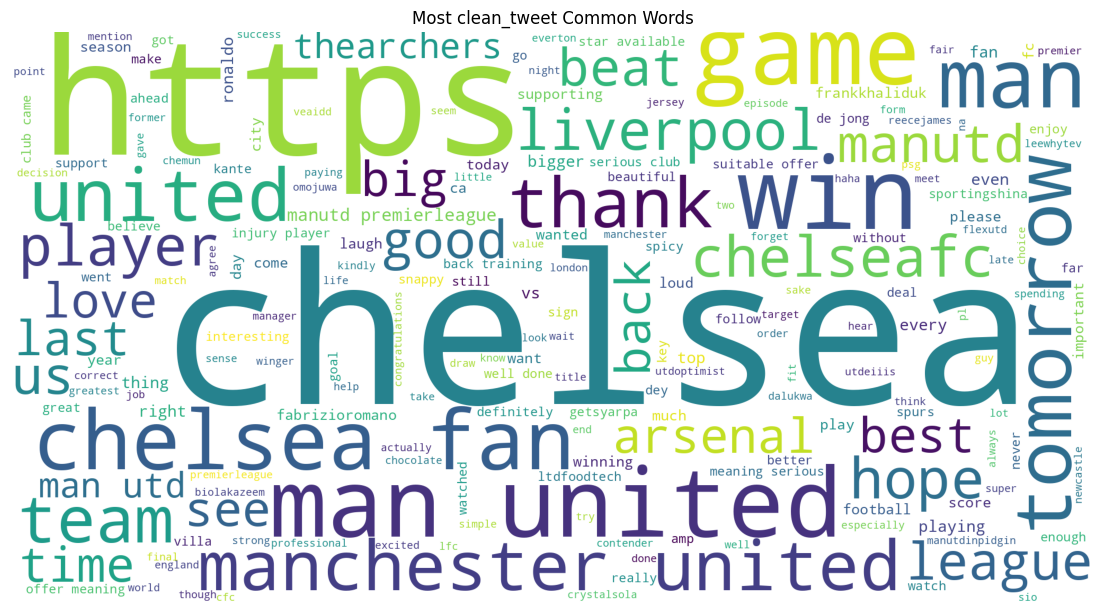

In [27]:
word_cloud(positive_df, column_name="clean_tweet")

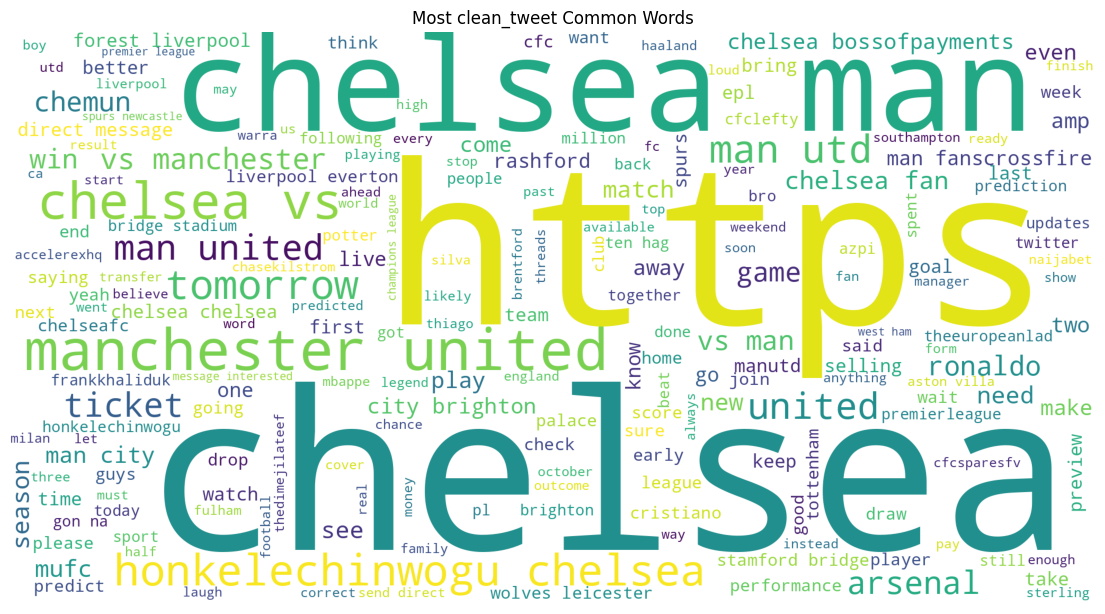

In [28]:
word_cloud(neutral_df, column_name="clean_tweet")

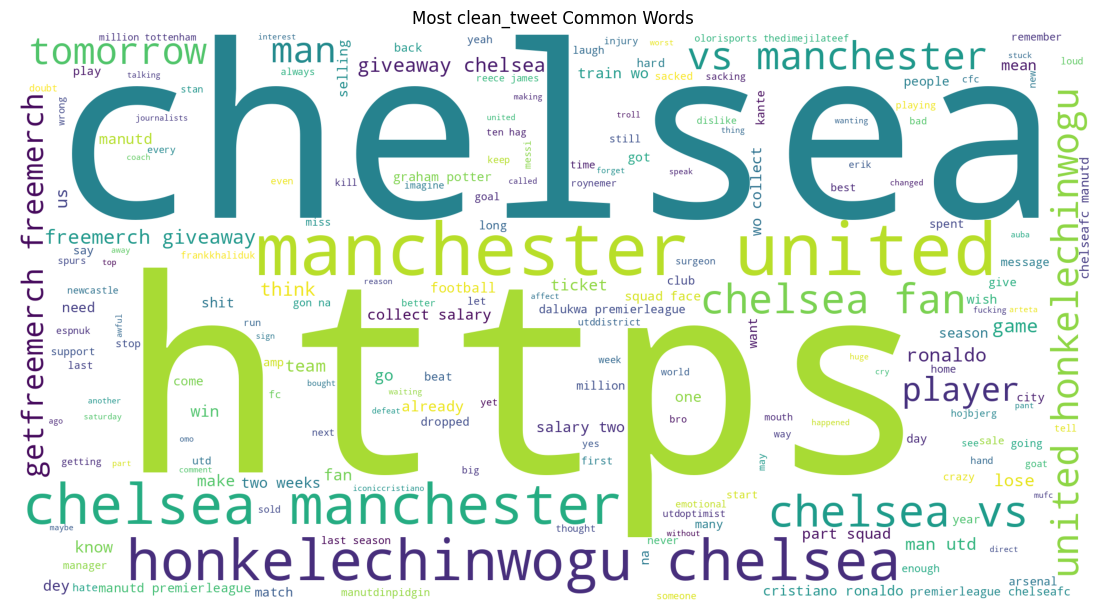

In [29]:
word_cloud(negative_df, column_name="clean_tweet")

# Save tweets

In [30]:
df.to_csv("Tweets_Sentiment_Analysis_Results.csv", index=False)
print("Done!")

Done!
